-----
<div> <center> ESPACIO PARA BANNER DE LA MAESTRIA </center> </div>   

-----

# Hotspots

El contenido de este notebook es tomado del siguiente [enlace](https://darribas.org/gds_scipy16/). Para más información visitar las referencias

El objetivo de este notebook es mostrar las principales técnicas para analizar patrones espaciales de datos que sean puntos. Para eso vamos a utilizar la información de algunos AirBnbs de la ciudad de Austin. 

Para ejecutar los comandos de este modulo va a necesitar cargar las siguientes librerías:

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import mplleaflet as mpll

plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.figsize"] = [8, 4]

## Limpieza de datos

Definimos el directorio de nuestros datos. Esta línea debe ajustarla para la ruta particular de su computador

In [2]:
listings_link = './data/listings.csv.gz'

El nombre del archivo que contiene nuestros datos es `listings.csv`. Este contiene información sobre inmuebles listados en AirBnb en la ciudad de Austin.

In [3]:
lst = pd.read_csv(listings_link)
lst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5835 entries, 0 to 5834
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                5835 non-null   int64  
 1   listing_url                       5835 non-null   object 
 2   scrape_id                         5835 non-null   int64  
 3   last_scraped                      5835 non-null   object 
 4   name                              5835 non-null   object 
 5   summary                           5373 non-null   object 
 6   space                             4475 non-null   object 
 7   description                       5832 non-null   object 
 8   experiences_offered               5835 non-null   object 
 9   neighborhood_overview             3572 non-null   object 
 10  notes                             2412 non-null   object 
 11  transit                           3492 non-null   object 
 12  thumbn

Vamos a visualizar rápidamente un diagrama de cajas y bigotes para darnos cuenta si existen ubicaciones geográficas lejanas al gran conglomerado de los datos que puedan entorpecer nuestro análisis.

<AxesSubplot:>

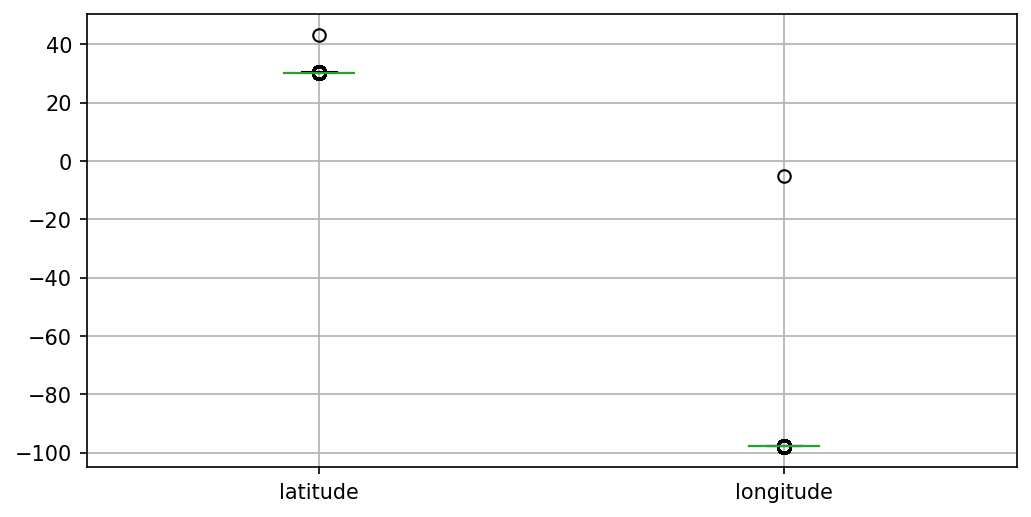

In [4]:
lst[["latitude", "longitude"]].boxplot()

Existe un inmueble ubicado en una longitud de al rededor de -5. Vamos a eliminar este dato

In [5]:
lst = lst.loc[lst.longitude < -80,].reset_index(drop = True)

## Visualización
Comencemos visualizando la distribución conjunta de la latitud y la longitud de los inmuebles

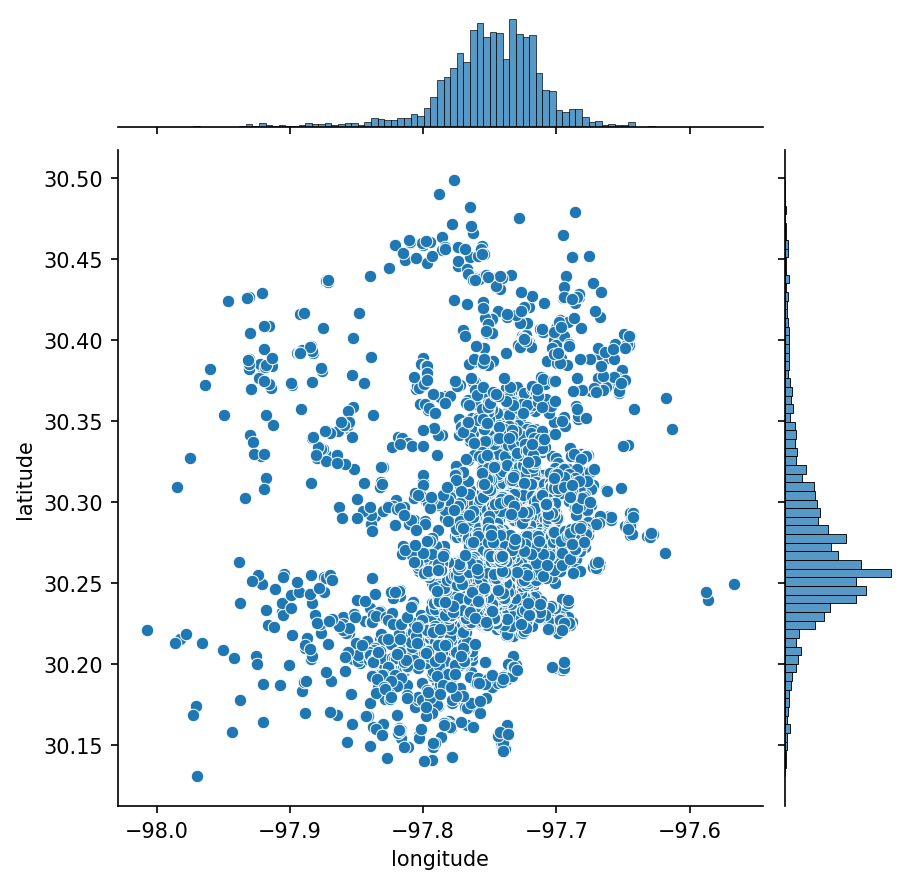

In [6]:
sns.jointplot(data = lst, x = "longitude", y = "latitude");

En principio esta aproximación nos entrega algo de luces sobre la distribución de los puntos. Sin embargo, sin un contexto geográfico es difícil interpretar este gráfico por sí solo. Más aún, se ve que la mayoría de los inmuebles están aglomerados en el centro del gráfico, por lo cual no es claro como analizar esta información que se sobrepone en esta visualización.

Para sobreponernos a este problema podemos visualizar nuestros puntos sobre un mapa interactivo. La forma más sencilla de hacerlo es haciendo uso de la librería [`leaflet`](https://leafletjs.com/).

Sin embargo, note que nuestra base tiene más de 5 mil observaciones, por lo que visualizarla toda en el mapa interactivo puede tardar un tiempo considerable. Por lo pronto, mostraremos 100 observaciones aleatorias.

In [7]:
np.random.seed(666) # Esta semilla garantiza la replicabilidad de la gráfica
indices = np.arange(lst.shape[0]) 
np.random.shuffle(indices)
fig, ax = plt.subplots(1, figsize = (6, 6))
lst.iloc[indices[:100],:].plot(kind = 'scatter', x = 'longitude', y = 'latitude',
    s = 30, linewidth = 0, ax = ax)
mpll.display(fig = fig)

C:\Users\User\anaconda3\lib\site-packages\mplleaflet\mplexporter\exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
C:\Users\User\anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Fíjese que el cúmulo de puntos que veíamos en la gráfica anterior corresponde al centro de Austin. 

## Alternativas para visualizar muchos más datos

`Leaflet` es el paquete que permite hacer visualizaciones de forma más rápida e intuitiva. Sin embargo, en la medida que el número de observaciones a visualizar crece, este paquete se comienza a quedar corto.

Una gran alternativa para visualizar muchos más datos es `bokeh`, un submodulo del paquete `datashaded`. (Para una introducción más completa a este paquete puede revisar este [enlace](https://anaconda.org/jbednar/nyc_taxi/notebook)).

Este paquete es un poco más técnico que `Leaflet` por lo cual requiere que se transformen los datos antes de visualizarlos. Lo primero será re proyectar nuestras latitudes/longitudes a Web Mercator. 

Antes de continuar, es importante mencionar que existen muchos tipos de "proyecciones". Estas básicamente corresponden a las transformaciones necesarias para mostrar el globo terráqueo en una superficie plana de dos dimensiones. Todas las proyecciones requieren distorsionar la superficie en la que se muestran los datos, por lo que las proporciones entre los objetos que se muestran, las distancias u otra característica del mapa puede no corresponder a una fiel copia de la realidad. Por tal motivo, es importante investigar que tipos de distorsiones o supuestos hace la proyección que vamos a emplear a la hora de visualizar nuestros datos. A pequeñas escala las variaciones entre una proyección u otra pueden ser irrelevantes. En nuestro caso estaremos usando Web Mercator la cual es muy popular entre los servicios de mapas online, de hecho es la que incorpora google maps desde 2005.

In [8]:
from shapely.geometry import Point

# Convertimos las coordenadas en puntos
puntos = lst[['longitude', 'latitude']].apply(Point, axis = 1)
# Convertimos los puntos en un objeto GeoSeries. Note que estamos definiendo explicitamente
# la proyección inicial de los puntos
xys_wb = gpd.GeoSeries(puntos, crs = "epsg:4326")
# Vamos a reproyectar a Web Mercator
xys_wb = xys_wb.to_crs(epsg = 3857)
# Separamos las coordenadas en x e y
x_wb = xys_wb.apply(lambda i: i.x)
y_wb = xys_wb.apply(lambda i: i.y)

Ahora que tenemos nuestros objetos en el formato adecuado. Vamos a crear una función para visualizar el mapa con `bokeh`

In [9]:
from bokeh.plotting import figure, output_notebook, show

output_notebook() # Se usa cuando se va a desplegar un mapa dentro de un Jupyter Notebook

# Extraemos los puntos más extremos para definir los límites del mapa
minx, miny, maxx, maxy = xys_wb.total_bounds
y_range = miny, maxy # Lo vamos a utilizar en todas las visualizaciones
x_range = minx, maxx # Lo vamos a utilizar en todas las visualizaciones

def base_plot(tools = 'pan,wheel_zoom,reset', plot_width = 600, plot_height = 400, **plot_args):
    p = figure(tools = tools, plot_width = plot_width, plot_height = plot_height,
        x_range = x_range, y_range = y_range, outline_line_color = None,
        min_border = 0, min_border_left = 0, min_border_right = 0,
        min_border_top = 0, min_border_bottom = 0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

# Definimos que nuestros puntos tengan color morado (#800080) y sean de tamaño 4
options = dict(line_color = None, fill_color = '#800080', size = 4)

Loading BokehJS ...

In [10]:
from bokeh.tile_providers import STAMEN_TERRAIN, get_provider

# Creamos un mapa delimitado por las coordenadas más extremas 
p = base_plot()
# Necesitamos importar un proveedor de los servicios de cartografía. Este proveedor será el
# que visualizará las calles, los ríos, parques, nombres de las ciudades, etc.
# Para ver los proveedores disponibles puede ingresar a https://docs.bokeh.org/en/latest/docs/reference/tile_providers.html#bokeh-tile-providers
# Adicionalmente, puede utilizar los servicios de Google, sin embargo deberá contar con un API: https://docs.bokeh.org/en/latest/docs/reference/plotting/gmap.html#bokeh.plotting.gmap

cartografia = get_provider(STAMEN_TERRAIN)
p.add_tile(cartografia)

# Le añadimos las ubicaciones de los inmuebles como puntos
p.circle(x = x_wb, y = y_wb, **options)

# Visualizamos nuestro mapa
show(p)

Note que `bokeh` es sustancialmente más veloz que `leaflet`. 

Cuando el mapa se presenta en la vista que permite observar todos los puntos se tiene el problema de que cuando se visualizan muchos inmuebles se forman grandes conglomerados de círculos que no permiten discernir la posición de cada quién. Parte de las ventajas de tener estos mapas interactivos es que permiten hacer zoom-in y de este modo adentrarse en las zonas de mayor densidad para que el tamaño relativo de los objetos se ajuste de tal modo que el mapa pueda ser interpretable.

Sin embargo, existen otras técnicas que permiten capturar el patrón general de la información geográfica. Tal vez la más conocida es la Estimación de Densidad Kernel (KDE por sus siglas en inglés) la cual se aproxima a la intensidad de los puntos a través de una superficie continua. Para aprender más de este método le sugerimos comenzar leyendo [esta entrada](https://pro.arcgis.com/es/pro-app/latest/tool-reference/spatial-analyst/how-kernel-density-works.htm).

Para este caso vamos a mostrar otra técnica más reciente desarrollada en la investigación titulada "Abstract rendering: out-of-core rendering for information visualization" desarrollada por Cottam, Lumsdaine y Wang (2014). La implementación en Python se encuentra en el paquete [`datashader`](https://github.com/holoviz/datashader).


La ventaja clave de `datashader` es que separa el procesamiento de puntos del trazado del mapa. Por ende esta aproximación es escalable a datos realmente grandes (por ejemplo, millones de puntos). Esencialmente, el enfoque se basa en generar una cuadrícula muy fina, contar puntos dentro de píxeles y codificar el conteo en un esquema de color. En nuestro mapa, esto no es particularmente efectivo porque no tenemos demasiados puntos (el gráfico anterior es probablemente más efectivo) y esencialmente hay un píxel por ubicación de cada punto. Sin embargo, esperamos que este ejemplo muestre cómo crear este tipo de mapas escalables.

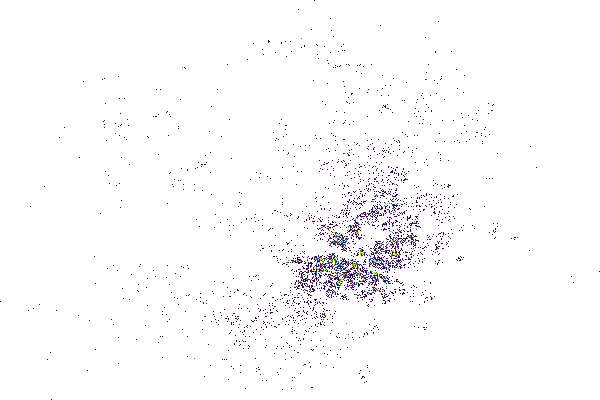

In [39]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import viridis

# Creamos un dataframe con los puntos a visualizar
puntos = pd.DataFrame({'x': x_wb, 'y': y_wb})
# Creamos la variable count en donde vamos a contar el número de inmuebles por pixel
puntos['count'] = 1

# Primero creamos el espacio donde vamos a dibujar el mapa (lienzo/canvas)
cvs = ds.Canvas(plot_width = 600, plot_height = 400, x_range = x_range, y_range = y_range)

# Agregamos los puntos
agg = cvs.points(puntos, 'x', 'y',  ds.count('count'))

# Vamos a visualizar solo grandes aglomeraciones por lo que todos los conteos por debajo del 
# percentil 90 se eliminan
umbral = np.percentile(agg, 90)
agg = agg.where(agg > umbral)

# Convertimos el DataArray en una imagen eligiendo un color de píxel RGBA para cada valor.
# Como nuestros datos son en 2D, los canales RGB se calculan a partir de una interpolación en el 
# mapa de colores dado.
img = tf.shade(agg, cmap = viridis, how = 'eq_hist')

# Para aprender sobre otro tipo de agregaciones puede visitar la documentación del paquete
# en el siguiente enlace: https://datashader.org/getting_started/Pipeline.html

img

In [51]:
import holoviews as hv
from holoviews.element.tiles import StamenToner
from holoviews.operation.datashader import datashade

# Importamos la cartografía y definimos el tamaño del mapa
cartografia = StamenToner().opts(width = 600, height = 400)

# Convertimos nuestro data frame en un objeto holoviews
puntos_hv = hv.Points(puntos, ['x', 'y'])

datos = datashade(puntos_hv, cmap=viridis, width=600, height=400)

mapa = cartografia * datos

mapa

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [x,y]   (R,G,B,A)

## Estimación de Densidad Kernel
En estadística, la Estimación de Densidad Kernel es una forma no paramétrica de estimar la función de densidad de probabilidad de una variable aleatoria. La estimación de la densidad del kernel es un problema fundamental de suavización de datos en el que se hacen inferencias sobre la población, basándose en una muestra de datos finita.

La idea detrás de este método es contar el número de puntos de forma continua. En lugar de utilizar un recuento discreto, en el que se incluye un punto en el recuento si se encuentra dentro de un determinado límite y se ignora en caso contrario, se utilizan funciones (kernels) que incluyen los puntos pero dan diferentes pesos a cada uno de ellos dependiendo de la distancia a la que se encuentre el punto que estamos contando.

Formalmente, podríamos definir el método de la siguiente manera: sean $(x_1, x_2, \cdots, x_n)$ muestras independientes e idénticamente distribuidas extraídas de alguna distribución univariada con una densidad desconocida $f$ en cualquier punto dado $x$. Nos interesa estimar la forma de esta función $f$. Su estimador de la densidad del kernel es:

$$\hat{f_h}(x)=\frac{1}{n}\sum_{i=1}^n K_h(x-x_i)=\frac{1}{nh}\sum_{i=1}^nK\left(\frac{x-x_i}{h}\right)$$

Donde $K$ es una función no negativa llamada kernel y $h > 0$ es un parámetro de suavización llamado ancho de banda. Un kernel con el subíndice $h$ ($K_h$) se denomina kernel escalado y se define como $K_h(x) = 1/h K(x/h)$. Intuitivamente, se busca elegir $h$ tan pequeño como los datos lo permitan; sin embargo, existe un trade-off entre sesgo y varianza del estimador. 

En la literatura se suelen utilizar diferentes funciones kernel: uniforme, triangular, bi-peso, tri-peso, Epanechnikov, normal, entre otras. Se puede probar que el kernel de Epanechnikov es óptimo en un sentido de error cuadrático medio, aunque en la práctica la escogencia del tipo de función Kernel entre las opciones listadas anteriores no afecta de manera relevante los resultados. Adicionalmente, debido a sus convenientes propiedades matemáticas, a menudo se utiliza el kernel normal, que significa $K(x) = \phi(x)$, donde $\phi$ es la función de densidad normal estándar.

Típicamente la función kernel exhibe las siguientes propiedades:
1. Simetría: $K(u)=K(-u)$.
2. Normalizada de modo que $\int_{-\infty}^\infty K(u) du = 1$.
3. Monótona decreciente tal que $K'(u)<0$ cuando $u>0$.
4. Valor esperado igual a 0: $E[K]=0$.

Para construir una Estimación de Densidad Kernel en Python podemos correr el siguiente comando:

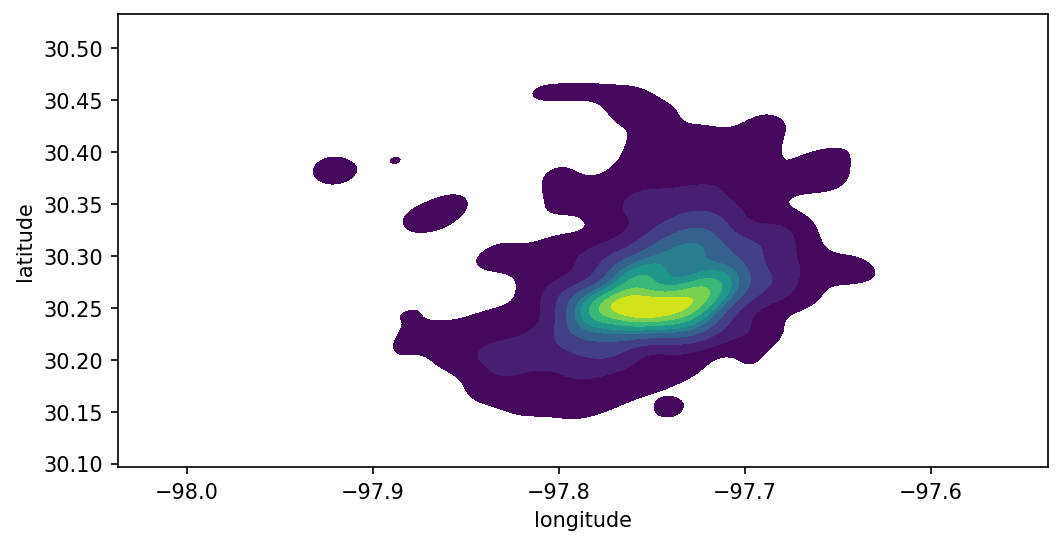

In [55]:
sns.kdeplot(data = lst, x= 'longitude', y = 'latitude', shade = True, cmap = 'viridis');

Para añadir más capas de información de datos, se sigue el mismo proceso que se haría en caso de querer añadir más capas a un gráfico de `matplotlib`. Por ejemplo, carguemos los códigos postales de Austin:

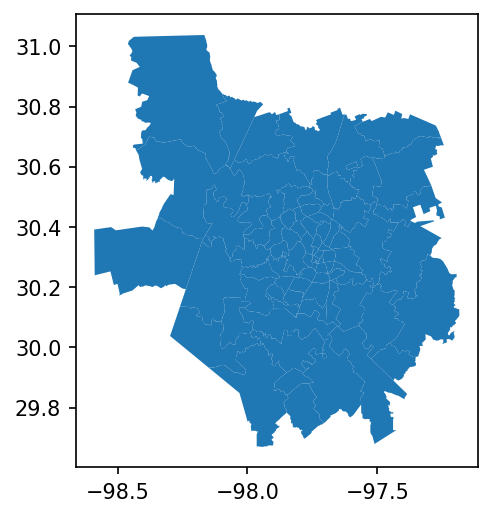

In [56]:
zc = gpd.read_file('./data/Zipcodes.geojson')
zc.plot();

Para combinar ambos gráficos:

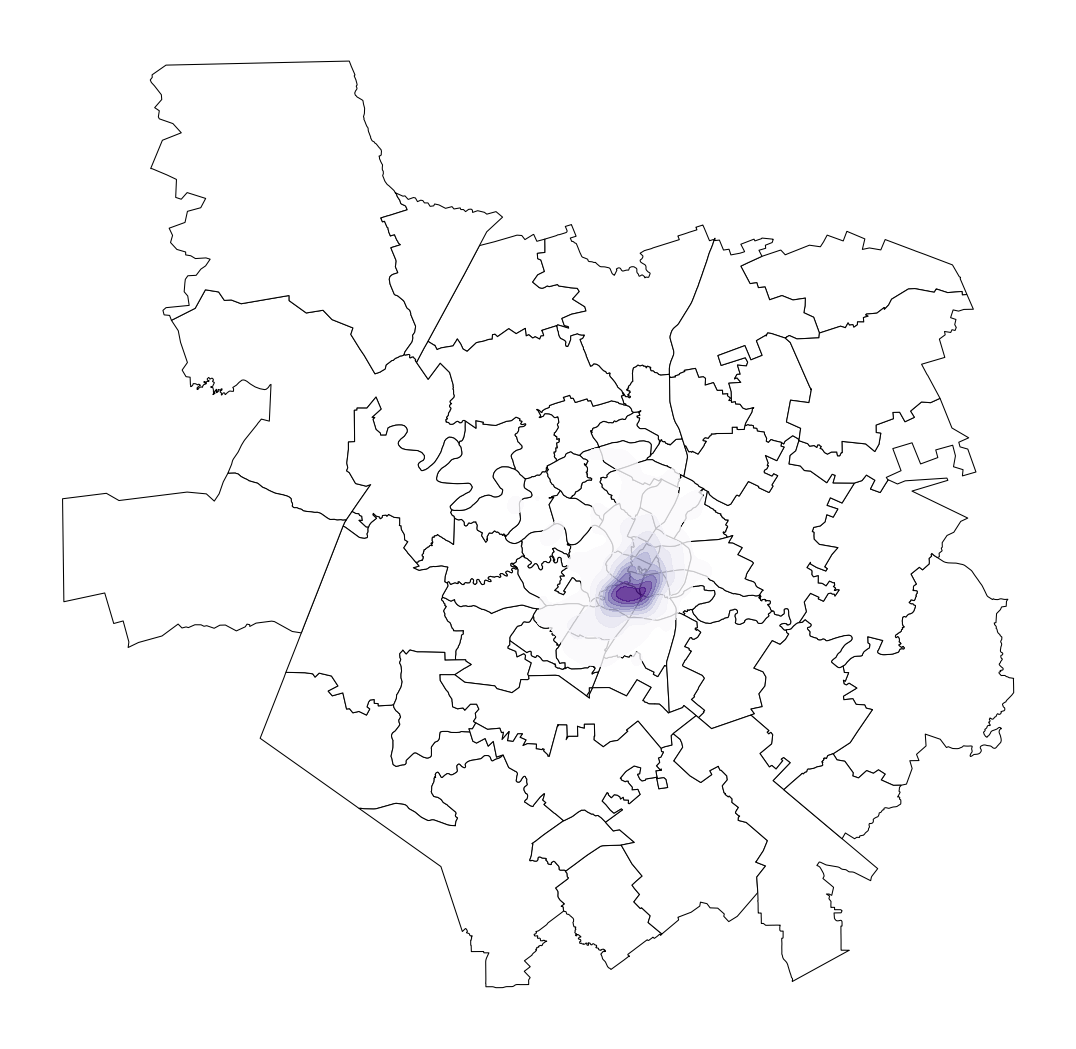

In [65]:
# Layout
fig, ax = plt.subplots(1, figsize = (9, 9))
# Mapa de Austin 
zc.plot(color = 'white', edgecolor = 'black', linewidth = 0.5, ax = ax)
# Estimación de Kernel
sns.kdeplot(data = lst, x = 'longitude', y = 'latitude', shade = True, 
    cmap = 'Purples', ax = ax, alpha = 0.8);
# Quitar ejes
ax.set_axis_off()
# Ajustar el tamaño de los ejes
plt.axis('equal')
plt.show()

# Referencias
- Cottam, J., Lumsdaine, A., & Wang, P. (2014). Abstract rendering: Out-of-core rendering for information visualization. Proceedings of SPIE - The International Society for Optical Engineering. 9017. 90170K. 10.1117/12.2041200
- Rey, S., & Arribas-Bel, D. (nd). Introduction Geographic Data Science with PySAL and the pydata stack
